# Label Models
Demonstrates how to use label models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.notebook_utils import load_wrench_dataset, MetricsMaker, datasets

datasets

['imdb',
 'yelp',
 'youtube',
 'sms',
 'agnews',
 'trec',
 'spouse',
 'cdr',
 'semeval',
 'chemprot',
 'commercial',
 'tennis',
 'basketball',
 'census']

Choose your dataset here

In [6]:
dataset = "cdr"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:149: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.6673913043478261, 0.33260869565217394]

In [8]:
polarities

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [9]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,1,0.032,1.0,0.028,0.026,0.013
1,1,0.022,1.0,0.018,0.018,0.006
2,1,0.004,1.0,0.004,0.004,0.002
3,0,0.048,1.0,0.048,0.048,0.020
4,0,0.088,1.0,0.087,0.087,0.038
5,0,0.188,1.0,0.170,0.145,0.092
6,0,0.014,1.0,0.014,0.013,0.009
7,1,0.018,1.0,0.018,0.018,0.005
8,1,0.020,1.0,0.020,0.020,0.008
9,0,0.047,1.0,0.047,0.047,0.017


Scoring utils:

In [10]:
y_test = test["label"].astype(int).values

In [11]:
Metrics = MetricsMaker(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [12]:
from flippers.models import Voter

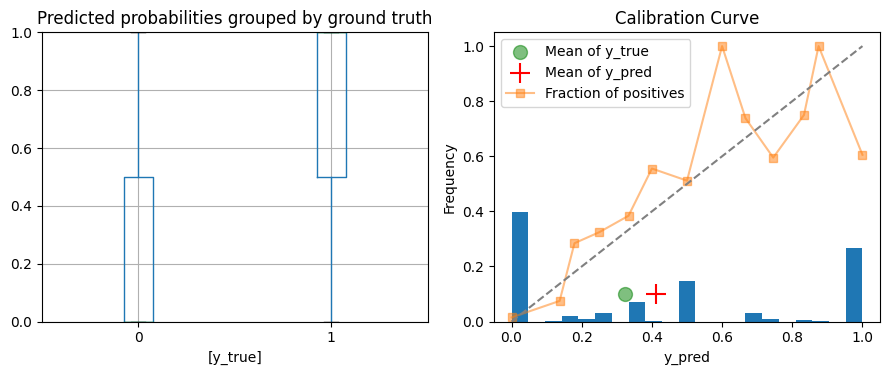

{'F1': 0.613,
 'Average_Precision': 0.59,
 'AUC': 0.828,
 'Accuracy': 0.753,
 'Balanced_Accuracy': 0.714}

In [13]:
voter = Voter(polarities)
Metrics.score(voter, name="Majority Vote")

# Balanced Voter model

It is possible to balance out a voter model by using the fit method.

This is helpful when labeling functions have a higher match rate for some classes than others.

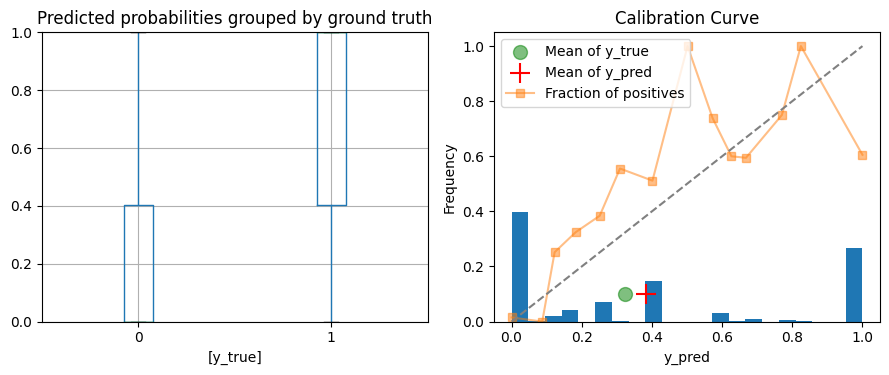

{'F1': 0.613,
 'Average_Precision': 0.59,
 'AUC': 0.828,
 'Accuracy': 0.753,
 'Balanced_Accuracy': 0.714}

In [14]:
# Reweigh the votes
voter.fit(L_train, class_balances)
Metrics.score(voter, name="Weighted Vote")

## `flippers`' Snorkel Model

The `flippers` SnorkelModel is inspired by the current LabelModel in `snorkel` but is improved for simplicity, balancing and also accuracy.

Training a label model with Flippers is very simple:

In [15]:
from flippers.models import SnorkelModel

In [16]:
# Specify the polarities and class balances when initializing the model
model = SnorkelModel(polarities=polarities, class_balances=class_balances)

# Fit the model, refer to documentation for more details on hyperparameters
model.fit(
    L_train,
    learning_rate=5e-3,
    num_epochs=50,
    k=1e-2,
    verbose=True,
)

Epoch 50/50 | Loss 0.1727: 100%|██████████| 50/50 [00:00<00:00, 245.82it/s]


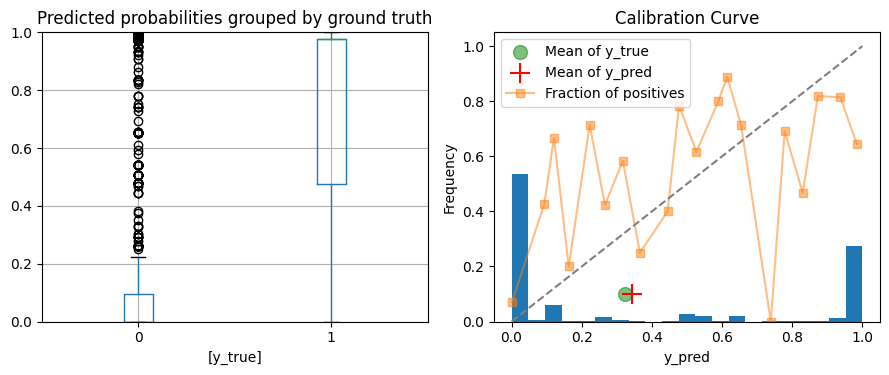

{'F1': 0.681,
 'Average_Precision': 0.651,
 'AUC': 0.86,
 'Accuracy': 0.784,
 'Balanced_Accuracy': 0.765}

In [17]:
Metrics.score(model, name="flippers")

In [18]:
# All models can be easily saved and loaded

# model.save("snorkel_model.pkl")

# model = SnorkelModel.load("snorkel_model.pkl")

# VAE

Weak VAEs are currently experimental.

Their purpose is to be able to handle correlated LFs 
and refine from the Naive Bayes assumption used by snorkel and the SnorkelModel.

In [19]:
from examples.Experiments._vae import WeakLabelVAE

Epoch [76/76]: 100%|██████████| 76/76 [00:16<00:00,  4.49it/s, Loss=18.1]


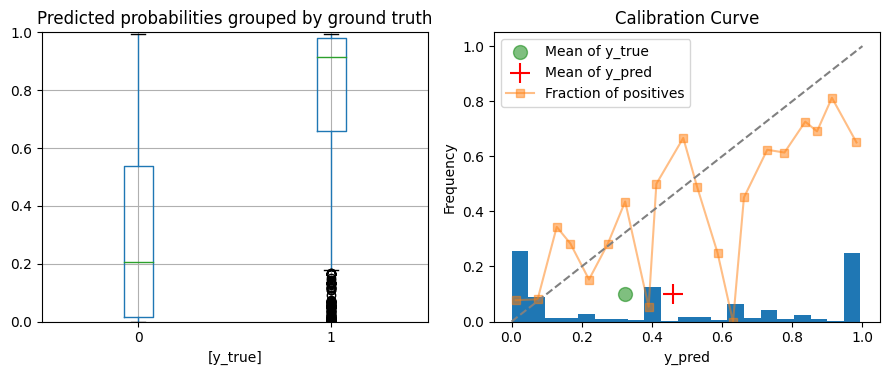

{'F1': 0.695, 'Average_Precision': 0.631, 'AUC': 0.808, 'Accuracy': 0.764, 'Balanced_Accuracy': 0.782}


In [20]:
vae = WeakLabelVAE(polarities=polarities, class_balances=class_balances, latent_dim=8) #.to("cuda")
vae.fit(L_train, batch_size=128)
print(Metrics.score(vae, name="WeakLabelVAE"))